<a href="https://colab.research.google.com/github/Jiadia22/2024-deep-learning-training/blob/main/DL_training_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

경사 하강법을 이용한 얕은 신경망 학습

In [68]:
import tensorflow as tf
import numpy as np

In [69]:
#하이퍼 파라미터 설정
EPOCHS = 1000

In [70]:
#네트워크 구조 정의
#얕은 신경망. 입력계층:2, 은닉계층:128(sigmoid activation),출력계층:10(softmax activation)

In [71]:
class MyModel(tf.keras.Model): #초기화 메서드
  def __init__(self):
    super(MyModel,self).__init__() #tf.keras.Model클래스의 초기화 메서드 호출.


    self.d1 = tf.keras.layers.Dense(128,input_dim=2,activation='sigmoid')
    self.d2 = tf.keras.layers.Dense(10,activation='softmax') #input_dim=128

  def call(self,x,training=None,mask=None): #호출 메서드
    x = self.d1(x)
    return self.d2(x)

#입력 데이터에 대해 순전파를 수행하여 클래스의 확률 분포를 출력하는 간단한 신경망 모델.

In [84]:
#학습 루프 정의
@tf.function #파이썬 코드를 tensorflow 그래프로 변환하여 성능을 향상시키는 역할
def train_step(model,inputs,labels,loss_object,optimizer,train_loss,train_metric):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = loss_object(labels,predictions)
  gradients = tape.gradient(loss,model.trainable_variables) #df(x)/dx, 손실에 대한 모델의 각 변수에 대한 경사를 계산

  optimizer.apply_gradients(zip(gradients,model.trainable_variables))
  #옵티마이저를 사용하여 모델의 변수들을 업데이트합니다.
  train_loss(loss) #현재의 손실을 train_loss에 기록
  train_metric(labels,predictions) #정확도 등을 계산하고 기록합니다

In [85]:
#데이터셋 생성,전처리
np.random.seed(0)

pts = list() #2개
labels = list() #10개
center_pts_list = np.random.uniform(-8.0,8.0,(10,2)) #10개의 중심점 생성
for label,center_pts in enumerate(center_pts_list): #각 중심점 주변에 표준 정규 분포를 따르는 100개의 데이터 포인트 생성
  for _ in range(100):
    pts.append(center_pts + np.random.randn(*center_pts.shape))
    labels.append(label)

pts = np.stack(pts,axis=0).astype(np.float32) #리스트를 넘파이
labels = np.stack(labels,axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((pts,labels)).shuffle(1000).batch(32)
#튜플형태로 데이터셋 생성, 1000개의 데이터를 섞기, 한 번에 처리할 수 있는 배치크기는 32.

In [86]:
#모델생성
model = MyModel()

In [87]:
#손실 함수 및 최적화 알고리즘 설정
#(crossentropy, adam optimizer)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy() #크로스엔트로피를 최소화 해야함
optimizer = tf.keras.optimizers.Adam() #모델의 가중치 업데이트

In [88]:
#평가 지표 설정 (accuracy)
train_loss = tf.keras.metrics.Mean(name='train_loss') #손실 값을 평균화 하여 기록
train_accuracy = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_accuracy') #정확도 평

In [89]:
#학습루프
for epoch in range(EPOCHS):
  for x,label in train_ds: #32
    train_step(model,x,label,loss_object,optimizer,train_loss,train_accuracy)

  template = 'Epoch {}, Loss: {}, Accuracy: {}'
  print(template.format(epoch+1,
                        train_loss.result(), #현재까지의 평균 손실
                        train_accuracy.result()*100)) #현재까지의 평균 정확도

Epoch 1, Loss: 2.1445233821868896, Accuracy: 214.4814453125
Epoch 2, Loss: 1.9786162376403809, Accuracy: 198.13705444335938
Epoch 3, Loss: 1.8487874269485474, Accuracy: 185.23910522460938
Epoch 4, Loss: 1.7427117824554443, Accuracy: 174.69007873535156
Epoch 5, Loss: 1.6539747714996338, Accuracy: 165.75160217285156
Epoch 6, Loss: 1.5775152444839478, Accuracy: 158.1053009033203
Epoch 7, Loss: 1.5111072063446045, Accuracy: 151.37513732910156
Epoch 8, Loss: 1.4514983892440796, Accuracy: 145.46238708496094
Epoch 9, Loss: 1.3985669612884521, Accuracy: 140.1352081298828
Epoch 10, Loss: 1.350815773010254, Accuracy: 135.39553833007812
Epoch 11, Loss: 1.3073813915252686, Accuracy: 131.02806091308594
Epoch 12, Loss: 1.2674156427383423, Accuracy: 127.05763244628906
Epoch 13, Loss: 1.230790376663208, Accuracy: 123.38341522216797
Epoch 14, Loss: 1.1970512866973877, Accuracy: 119.99575805664062
Epoch 15, Loss: 1.1659789085388184, Accuracy: 116.86202239990234
Epoch 16, Loss: 1.136704683303833, Accurac

In [ ]:
#데이터셋 및 학습 파라미터 저장
np.savez_compressed('ch2_dataset.npz',inputs=pts,labels=labels) #압축하여 저장

w_h,b_h = medel.d1.get_weights() #히든레이어에 weight와 bias
w_o,b_o = medel.d2.get_weights() #아웃풋레이어에 weight와 bias
w_h = np.transpose(w_h)
w_o = np.transpose(w_o)
np.savez_compressed('ch2_dataset.npz',
                    w_h=w_h,
                    b_h=b_h,
                    w_o=w_o,
                    b_o=b_o)

수치 미분을 이용한 심층 신경망 학습

In [6]:
import time
import numpy as np

In [7]:
#유틸리티 함수
epsilon = 0.0001

def _t(x):
  return np.transpose(x)

def _m(A,B):
  return np.matmul(A,B)

def sigmoid(x):
  return 1 / (1+np.exp(-x))

def mean_squared_error(h,y):
  return 1/2*np.mean(np.square(h-y))

In [8]:
#뉴련구현
class Neuron:
  def __init__(self,W,b,a):
    #Model Parameter
    self.W = W
    self.b = b
    self.a = a

    #Gradients
    self.dw = np.zeros_like(self.W)
    self.db = np.zeros_like(self.b)

  def __call__(self,x):
    return self.a(_m(_t(self.W),x)+self.b) #activation((W^T)x+b)
    #~~

역전파 학습법을 이용한 심층 신경망 학습

In [41]:
import time
import numpy as np

In [42]:
#유틸리티 함수
epsilon = 0.0001

def _t(x):
  return np.transpose(x)

def _m(A,B):
  return np.matmul(A,B)

In [43]:
#Sigmoid 구현
class Sigmoid:
  def __init__(self):
    self.last_o = 1

  def __call__(self,x):
    self.last_o = 1/(1.0 + np.exp(-x))
    return self.last_o

  def grad(self): #sigmoid(x)(1-sigmoid(x))
    return self.last_o *(1-self.last_o)

In [44]:
#Mean Squared Error 구현
class MeanSquaredError:
  def __init__(self):
    #gradient
    self.dh = 1
    self.last_diff = 1

  def __call__(self,h,y): #1/2 *mean((h-y)^2)
    self.last_diff = h-y
    return 1/2 * np.mean(np.square(h-y))

  def grad(self): #h-y
    return self.last_diff


In [45]:
#뉴련 구현(fully-connected layer 구현)
class Neuron:
  def __init__(self,W,b,a_obj):
    #Model parameters
    self.W = W
    self.b = b
    self.a = a_obj()

    #gradient
    self.dW = np.zeros_like(self.W)
    self.db = np.zeros_like(self.b)
    self.dh = np.zeros_like(_t(self.W))

    self.last_x = np.zeros((self.W.shape[0])) #W grad를 위해서 마지막 x저장
    self.last_h = np.zeros((self.W.shape[1]))

  def __call__(self,x):
    self.last_x = x
    self.last_h = _m(_t(self.W),x) + self.b
    return self.a(self.last_h)

  def grad(self): #dy/dh = W
    return self.W * self.a.grad()

  def grad_W(self,dh):
    grad = np.ones_like(self.W)
    grad_a = self.a.grad()
    for j in range(grad.shape[1]): #dy/dw = x
      grad[:,j] = dh[j] *grad_a[j] * self.last_x
    return grad

  def grad_b(self,dh): #dy/dh = 1
    return dh*self.a.grad()

In [46]:
#심층신경망 구현
class DNN:
  def __init__(self,hidden_depth,num_neuron,input,output,activation=Sigmoid):
    def init_var(i,o):
      return np.random.normal(0.0,0.01,(i,o)),np.zeros((o,))

    self.sequence = list()
    #First hidden layer
    W,b = init_var(input,num_neuron)
    self.sequence.append(Neuron(W,b,activation))

    #Hidden Layers
    for index in range(hidden_depth):
      W,b = init_var(num_neuron,num_neuron)
      self.sequence.append(Neuron(W,b,activation))

    #Output layer
    W,b = init_var(num_neuron,output)
    self.sequence.append(Neuron(W,b,activation))

  def __call__(self,x):
    for layer in self.sequence:
      x = layer(x)
    return x

  def calc_gradient(self,loss_obj):
    loss_obj.dh = loss_obj.grad()
    self.sequence.append(loss_obj)
    #back-prop loop
    for i in range(len(self.sequence)-1,0,-1):
        l1 = self.sequence[i]
        l0= self.sequence[i-1]


        l0.dh = _m(l0.grad(),l1.dh)
        l0.dW = l0.grad_W(l1.dh)
        l0.db = l0.grad_b(l1.dh)

    self.sequence.remove(loss_obj)

In [47]:
#경사하강 학습법
def gradient_descent(network,x,y,loss_obj,alpha=0.01):
  loss = loss_obj(network(x),y) #Forward inference
  network.calc_gradient(loss_obj) #Back-propagation
  for layer in network.sequence:
    layer.W += -alpha * layer.dW
    layer.b += -alpha * layer.db
  return loss

In [49]:
#동작테스트
x = np.random.normal(0.0,1.0,(10,))
y = np.random.normal(0.0,1.0,(2,))

t = time.time()
dnn = DNN(hidden_depth=5,num_neuron=32,input=10,output=2,activation=Sigmoid)
loss_obj = MeanSquaredError()
for epoch in range(100):
  loss = gradient_descent(dnn,x,y,loss_obj,alpha=0.01)
  print("Epoch {}: Test loss {}".format(epoch,loss))
print('{} seconds elapsed.'.format(time.time()-t))

Epoch 0: Test loss 0.36131266164945375
Epoch 1: Test loss 0.357288056485878
Epoch 2: Test loss 0.35330858289968736
Epoch 3: Test loss 0.3493755003403499
Epoch 4: Test loss 0.3454899609569206
Epoch 5: Test loss 0.341653009699399
Epoch 6: Test loss 0.3378655849874046
Epoch 7: Test loss 0.33412851990994746
Epoch 8: Test loss 0.33044254391656663
Epoch 9: Test loss 0.32680828495743447
Epoch 10: Test loss 0.3232262720281667
Epoch 11: Test loss 0.31969693807400124
Epoch 12: Test loss 0.3162206232076507
Epoch 13: Test loss 0.312797578195447
Epoch 14: Test loss 0.30942796816728924
Epoch 15: Test loss 0.30611187650732896
Epoch 16: Test loss 0.30284930888417705
Epoch 17: Test loss 0.299640197381633
Epoch 18: Test loss 0.2964844046934355
Epoch 19: Test loss 0.29338172834824483
Epoch 20: Test loss 0.290331904933918
Epoch 21: Test loss 0.28733461429307616
Epoch 22: Test loss 0.2843894836649205
Epoch 23: Test loss 0.2814960917511931
Epoch 24: Test loss 0.2786539726870468
Epoch 25: Test loss 0.2758626

텐서플로우/케라스 이론 및 실습

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mnist = keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train,x_test = x_train/225.0,x_test/225.0

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
#등등 실습 간단히 진행

In [6]:
#tensor=>tensorflow의 기본 data type
hello = tf.constant([3,3],dtype = tf.float32)
print(hello)

tf.Tensor([3. 3.], shape=(2,), dtype=float32)


In [7]:
x = tf.constant([[1.0,2.0],[3.0,4.0]])
print(x)
print(type(x))

tf.Tensor(
[[1. 2.]
 [3. 4.]], shape=(2, 2), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [8]:
#np.array나 list도 tensor로 바꿀 수 있다.
x_np = np.array([[1.0,2.0],
                 [3.0,4.0]])
x_np = tf.convert_to_tensor(x_np)
print(type(x_np))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [9]:
#tensor 를 np.array로 바꾸기
x.numpy()

array([[1., 2.],
       [3., 4.]], dtype=float32)

In [12]:
a = tf.ones((2,3))
b = tf.zeros((2,3))
c = tf.fill((2,3),2) #넘파이는 full
print(a)
print(b)
print(c)
#like는 타입까지 가져옴
d = tf.zeros_like(c)
e = tf.ones_like(c)
print(d)
print(e)

tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[0. 0. 0.]
 [0. 0. 0.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[2 2 2]
 [2 2 2]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[0 0 0]
 [0 0 0]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[1 1 1]
 [1 1 1]], shape=(2, 3), dtype=int32)


In [13]:
f = tf.eye(3)
print(f)

tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)


In [14]:
g = tf.range(10) #numpy에서는 arange
print(g)

tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


In [15]:
h = tf.random.uniform((2,2)) #np.rand 0-1사이
i = tf.random.normal((2,2)) #np.randn
print(h)
print(i)

tf.Tensor(
[[1.5556812e-04 8.5463905e-01]
 [8.6481702e-01 6.3538933e-01]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[ 0.14080335  0.20531832]
 [-0.49298513  0.2175819 ]], shape=(2, 2), dtype=float32)


In [18]:
#tensor의 속성 변
tensor = tf.random.normal((3,4))
tensor = tf.reshape(tensor,(4,3))
tensor = tf.cast(tensor,tf.int32)

print (tensor.shape)
print(tensor.dtype)

(4, 3)
<dtype: 'int32'>


In [23]:
#variable => 튜플같이 값 변경 불가
tensor = tf.ones((3,4))
v = tf.Variable(tensor)
print(v)

v[0,0].assign(2)
print(v)

#뺄셈
add = tf.ones(shape = (3,4))
v.assign_sub(add)

<tf.Variable 'Variable:0' shape=(3, 4) dtype=float32, numpy=
array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3, 4) dtype=float32, numpy=
array([[2., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)>


<tf.Variable 'UnreadVariable' shape=(3, 4) dtype=float32, numpy=
array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [24]:
#indexing과 slicing
a = tf.range(1,13)
a = tf.reshape(a,(3,4))
print(a)

tf.Tensor(
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]], shape=(3, 4), dtype=int32)


In [25]:
#indexing
print(a[1])
print(a[0,-1])

tf.Tensor([5 6 7 8], shape=(4,), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


In [26]:
#slicing
print(a[1:-1])
print(a[:2,2:])

tf.Tensor([[5 6 7 8]], shape=(1, 4), dtype=int32)
tf.Tensor(
[[3 4]
 [7 8]], shape=(2, 2), dtype=int32)


In [34]:
a = tf.range(16)
a = tf.reshape(a,(2,2,-1))
print(a)

b = tf.transpose(a,(2,0,1))
print(b)

tf.Tensor(
[[[ 0  1  2  3]
  [ 4  5  6  7]]

 [[ 8  9 10 11]
  [12 13 14 15]]], shape=(2, 2, 4), dtype=int32)
tf.Tensor(
[[[ 0  4]
  [ 8 12]]

 [[ 1  5]
  [ 9 13]]

 [[ 2  6]
  [10 14]]

 [[ 3  7]
  [11 15]]], shape=(4, 2, 2), dtype=int32)


In [37]:
#축에 따라 덧셈
z = tf.range(1,11)
z = tf.reshape(z,(2,5))
print(z)
print(tf.reduce_sum(z,axis=0))

tf.Tensor(
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]], shape=(2, 5), dtype=int32)
tf.Tensor([ 7  9 11 13 15], shape=(5,), dtype=int32)


In [38]:
c = tf.concat([z,z],axis=0)
print(c)

tf.Tensor(
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [ 1  2  3  4  5]
 [ 6  7  8  9 10]], shape=(4, 5), dtype=int32)


In [52]:
#dataset
mnist = keras.datasets.fashion_mnist
class_names = ['T-shirt/top','Trouser','Pellover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()
unique,counts = np.unique(train_labels,axis=-1,return_counts=True)

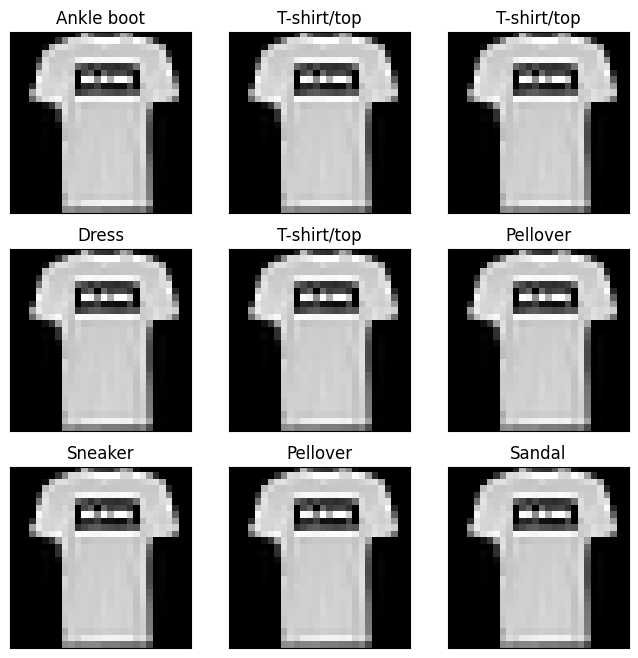

In [53]:
plt.figure(figsize=(8,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[1],cmap='gray')
  plt.title(class_names[train_labels[i]])
plt.show()

In [55]:
#data 전처리

#image를 0-1사이 값으로 만들기 위해서 255로 나누어줌
train_images = train_images.astype(np.float32)/255.
test_images = test_images.astype(np.float32)/255.

#one-hot encoding
train_labels = keras.utils.to_categorical(train_labels,10)
test_labels = keras.utils.to_categorical(test_labels,10)

In [56]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(buffer_size=1000000).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).batch(64)

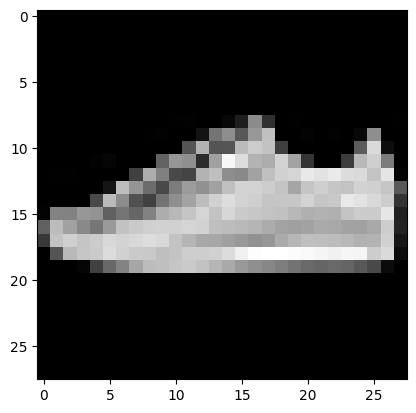

Label: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [58]:
imgs,lbs = next(iter(train_dataset))

img = imgs[0]
lb = lbs[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {lb}")

model

In [60]:
#keras Sequential API
def create_seq_model():
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(128,activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(10,activation='softmax'))
  return model

In [62]:
#keras Functional API
def create_func_model():
  inputs = keras.Input(shape=(28,28))
  flatten = keras.layers.Flatten(inputs)
  dense = keras.laters.Dense(128,activation='relu')(flatten)
  drop = keras.layers.Dropout(0.2)(dense)
  outputs = keras.layers.Dense(10,activation='softmax')(drop)
  model = keras.Model(inputs=inputs,outputs=outputs)

In [67]:
#model class subclassing
class SubClassModel(keras.Model):
  def __init__(self):
    self.flatten = keras.layers.Flatten(input_shape=(28,28))
    self.dense1 = keras.layers.Dense(128,activation='relu')
    self.drop = keras.layers.Dropout(0.2)
    self.dense2 = keras.layers.Dense(10,activation='softmax')
  def call(self,x,training=False):
    x=self.flatten(x)
    x = self.dense1(x)
    x = self.drop(x)
    return self.dense2(x)
